---
title: "Alignment and decontamination"
subtitle: "Cleaning ambient RNA in sequenced single cell data"
author:
    - name: Samuele Soraggi
      orcid: 0000-0002-1159-5535
      email: samuele@birc.au.dk
---

---
format:
  html:
   number-sections: true
   code-fold: false
   self-contained: false
   toc: true
  pdf:
   toc: true
bibliography: references.bib
---

This is a very short tutorial that will show you the tool `SoupX` (@young_soupx_2020) applied to remove ambient RNA in the sequenced data.

# UMI-based single cell data from microdroplets



The dataset is based on a **microdroplet-based method from 10X chromium**. We remember that a microdroplet single cell sequencing protocol works as follow:

- each cell is isolated together with a barcode bead in a gel/oil droplet

![Isolation of cells and beads into microdroplets.](images/droplet.gif){#fig-beads width=600}

- each transcript in the cell is captured via the bead and assigned a cell barcode and a transcript unique molecular identifier (UMI)
- 3' reverse transcription of mRNA into cDNA is then performed in preparation to the PCR amplification
- the cDNA is amplified through PCR cycles
  
![steps for the microdroplet-based single cell RNA sequencing after isolation.](images/10X.png){#fig-steps width=600}



## The raw data in practice

Let's look at a specific read and its UMI and cell barcode. The data is organized in paired-end reads (written on `fastq` files), where the first `fastq` file contains reads in the following format 

```
@SRR8363305.1 1 length=26
NTGAAGTGTTAAGACAAGCGTGAACT
+SRR8363305.1 1 length=26
#AAFFJJJJJJJJJJJJJJJJFJJJJ
```

Here, the first 16 characters `NTGAAGTGTTAAGACA` represent the cell barcode, while the last 10 characters `AGCGTGAACT` are the transcript UMI tag. The last line represents the quality scores of the 26 characters of barcode+UMI.

The associated second `fastq` file contains reads of 98nt as the following
```
@SRR8363305.1 1 length=98
NCTAAAGATCACACTAAGGCAACTCATGGAGGGGTCTTCAAAGA
    CCTTGCAAGAAGTACTAACTATGGAGTATCGGCTAAGTCAANCN
    TGTATGAGAT
+SRR8363305.1 1 length=98
#A<77AFJJFAAAJJJ7-7-<7FJ-7----<77--7FAAA--
    <JFFF-7--7<<-F77---FF---7-7A-777777A-<
    -7---#-#A-7-7--7--
```
The 98nt-long string of characters in the second line is a partial sequence of the cDNA transcript. Specifically, the 10X chromium protocol used for sequencing the data is biased towards the 3' end, because the sequencing is oriented from the 3' to the 5' end of the transcripts. The last line contains the corresponding quality scores.

## Alignment and expression matrix

We aligned the data with `cellranger`, a completely automatized [pipeline implemented by 10X](https://support.10xgenomics.com/single-cell-gene-expression/software/pipelines/latest/what-is-cell-ranger) for 10X-genomics data.

Apart from the data, the output contains an interactive document (`web_report.html`) reporting the quality of the data and a small preliminary UMAP plot and clustering . In this report it is especially instructive to look at the **knee plot**. 

The knee plot is created by plotting the number of unique molecular identifiers (UMIs) or reads against the number of cells sequenced, sorted in descending order. The UMIs or reads are a measure of the amount of RNA captured for each cell, and thus a measure of the quality of the data. The plot typically shows a **steep slope at the beginning, followed by a plateau, and then a gradual decrese into a second slope and a final plateau**. 

* The steep slope represents the initial cells that are of **high quality** and have the highest number of UMIs or reads. 
* The first plateau represents the cells that have **lower quality data**, and the gradual decrease represents the addition of droplets with even lower quality data. 
* Usually, beyond the first slope, you have droplets that are **either empty or of so poor quality**, that they are not worth keeping for analysis.
* The height of the last plateau gives you an idea of the **presence of ambient RNA** inside droplets. If the last plateau is located high up, then the corresponding amount of UMIs consist of background ambient RNA which likely pollutes all cells in your data.

Below, the knee plot from the `control 1` sample used in this course's analysis tutorial. You can see that around 10,000 cells with above ~1000 UMIs seems to be coinsidered of decent quality by `cellranger` (the part of line coloured in blue). Note that the last plateau is located at a very low amount of UMIs, meaning there is not really any relevant contamination from ambient RNA.

![Knee plot of the Control 1 sample of the tutorial. Note the lower plateau of ambient RNA](images/knee.png){width=600px #fig-knee}

::: {.callout-note title="Exercise" icon=false}

In the folder `Alignment_results` you have the document `web_summary.html` that shows you the quality report of your small toy dataset. **Take some time to look at it and explore what it contains** (Click on `Trust HTML` on the top menu if the html remains blank after opening it). 

:::


The background RNA (sequenced together with the transcript coming from the cell of interest) makes up the *ambient plateau*: the same background RNA is contained in empty droplets. If your dataset has extremely few UMI counts in empty droplets, then there is not much background RNA present - This is the best situation in which you can find yourself. See Exhibit A in @fig-bender.

If you have a dataset where you can identify an *empty droplet plateau* by eye (Exhibit B in @fig-bender), and these empty droplets have 50 or 100 or several hundred counts, then it can be advisable to use a specific software to remove the background transcripts (e.g. `CellBender` (@fleming_unsupervised_2023), `SoupX` (@young_soupx_2020)).

If you have a dataset with so much background RNA that you cannot identify the *empty droplet plateau* yourself by eye (Exhibit C in @fig-bender), then any software to remove background transcripts will also likely have a difficult time. Such the algorithms might be worth a try, but you should **strongly consider re-running the experiment, as the knee plot points to a real QC failure**

![Various cases of knee plot you can encounter from sequenced data. Figure from [the webpage of Cellbender.](https://cellbender.readthedocs.io/)](images/UMI_curve_tropes.png){width=600px #fig-bender}

## What does SoupX do

Before we get started with the specifics of example data sets and using the R package, it is worth understanding at a broad level what the problem this package aims to solve is and how it goes about doing it.

In droplet based, single cell RNA-seq experiments, there is always a certain amount of background mRNAs present in the dilution that gets distributed into the droplets with cells and sequenced along with th (see @fig-bender again)em  The net effect of this is to produce a background contamination that represents expression not from the cell contained within a droplet, but the solution that contained the cells.

This collection of cell free mRNAs floating in the input solution (henceforth referred to as "the soup") is created from cells in the input solution being lysed.  Because of this, the soup looks different for each input solution and strongly resembles the expression pattern obtained by summing all the individual cells.

The aim of this package is to provide a way to estimate the composition of this soup, what fraction of UMIs are derived from the soup in each droplet and produce a corrected count table with the soup based expression reoved.

The method to do this consists of three parts:

1. Calculate the profile of the soup.
2. Estimate the cell specific contamination fraction.
3. Infer a corrected expression matrix. 

In previous versions of SoupX, the estimation of the contamination fraction (step 2) was the part that caused the most difficulty for the user. The contamination fraction is parametrised as `rho` in the code, with `rho=0` meaning no contamination and `rho=1` meaning 100% of UMIs in a dropeNowon 1.3.0 onwards, an automated routine for estimating the contamination fraction is provided, which should be suitable is mostw it can fail.

While it is possible to run SoupX without clustering information, you will get far better results if some basic clustering is provided.  Therefore, it is **strongly** recommended that you provide some clustering information to SoupX.  If you are using 10X data mapp (as in our case)ed with cellranger, the default clustering produced by cellranger is automatically loaded and used.  The results are not strongly sensitive to thed similar results.


# Loading SoupX

We start by loading the necessary soupX package necessary for the analysis

In [1]:
library(SoupX)

Here `SoupX` performs the three main steps to decontaminate data. We only need to provide the alignment output, and the rest is automatical. You can find a more complex tutorial with all perks of `SoupX` [here](https://github.com/constantAmateur/SoupX/blob/master/vignettes/pbmcTutorial.Rmd)

Loading raw count data

Loading cell-only count data

Loading extra analysis data where available

216 genes passed tf-idf cut-off and 194 soup quantile filter.  Taking the top 100.

Using 714 independent estimates of rho.

Estimated global rho of 0.04

Warning message in sparseMatrix(i = out@i[w] + 1, j = out@j[w] + 1, x = out@x[w], :
“'giveCsparse' is deprecated; setting repr="T" for you”
Expanding counts from 15 clusters to 4931 cells.



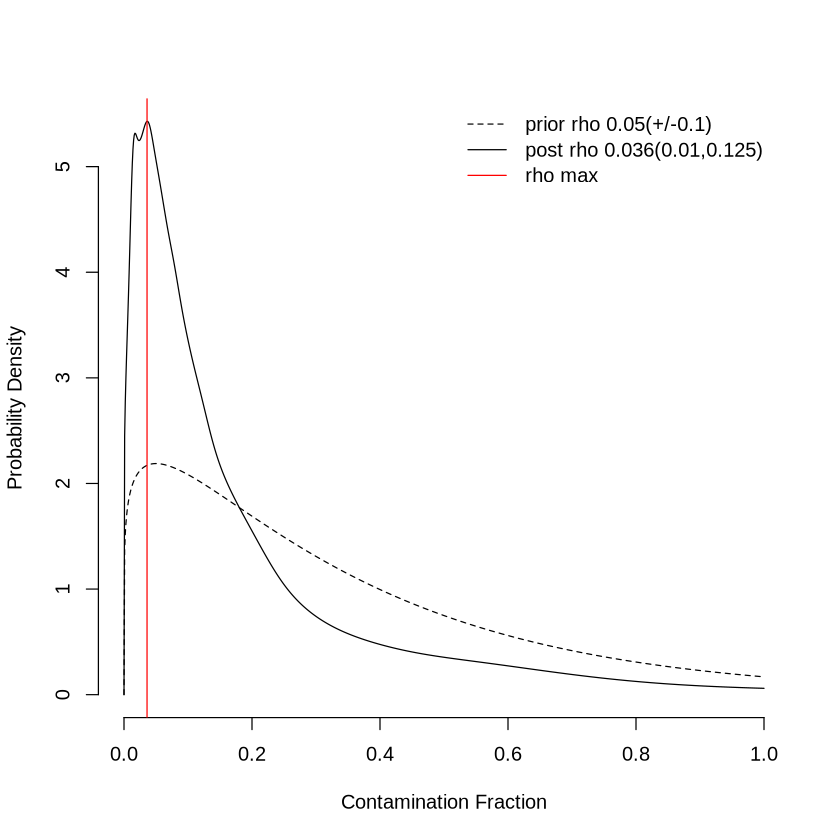

In [2]:
sc = load10X('./aligned_data/outs/')
sc = autoEstCont(sc)
out = adjustCounts(sc)

You should get an output showing - with a solid line - a distribution of the contamination of each gene. In our toy dataset, the contamination is pretty low, as it could be seen from the knee plot in the web report. 

You can also use the tSNE plot of a specific gene to reveal how many transcripts have been changed due to contamination.

In [ ]:
plotChangeMap(sc,out,'LotjaGi2g1v0360900')

::: {.callout-note title="Wrapping Up"}

This is the end of the tutorial - it was mostly ment to let you get confidence with a jupyter notebook and the data decontamination process. We will use decontamination also on the real dataset.

:::